In [95]:
!pip install bertviz
from transformers import AutoTokenizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [96]:
from bertviz.transformers_neuron_view import BertModel

In [97]:
from bertviz.neuron_view import show

In [98]:
model_name="bert-base-uncased"

In [99]:
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [100]:
model=BertModel.from_pretrained(model_name)

In [101]:
text="i put my money in the bank"

In [102]:
show(model,"bert",tokenizer,text,display_mode="light")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

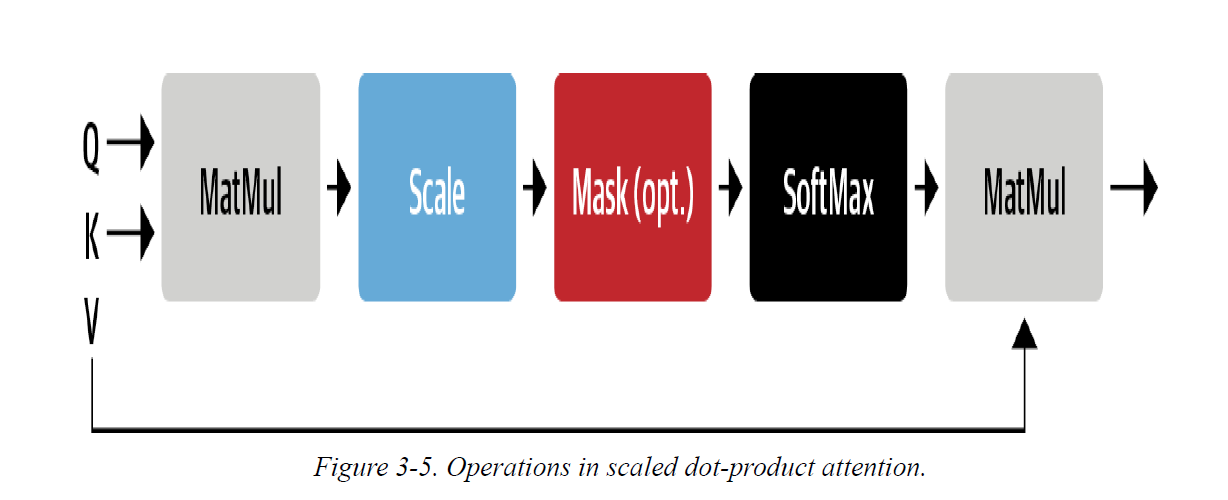


In [103]:
inputs=tokenizer(text,return_tensors="pt",add_special_tokens=False)

In [104]:
inputs

{'input_ids': tensor([[1045, 2404, 2026, 2769, 1999, 1996, 2924]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [105]:
import torch.nn as nn
from transformers import AutoConfig

In [106]:
config=AutoConfig.from_pretrained(model_name)

In [107]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [108]:
token_emb=nn.Embedding(config.vocab_size,config.hidden_size)
token_emb

Embedding(30522, 768)

# creating the query, key,and value vectors and calculate the attention scores using the dot-product as the similarity function

In [109]:
import torch
from math import sqrt

In [110]:
input_embeds=token_emb(inputs.input_ids)

In [111]:
input_embeds

tensor([[[-0.8293, -0.7178, -1.4779,  ..., -1.3938, -1.3422, -1.6373],
         [-0.9610, -1.3613,  0.6630,  ...,  0.0352,  0.6625,  1.6294],
         [ 1.2929, -0.6391, -0.9895,  ..., -1.0517,  0.4229,  1.1778],
         ...,
         [-0.5847,  0.6963, -1.8587,  ...,  0.9493, -0.8157,  0.8006],
         [-1.5755, -0.8949, -0.0169,  ..., -1.3224,  0.5125, -1.5639],
         [ 0.3295, -0.0889,  0.5274,  ...,  0.6649, -0.2223,  0.9261]]],
       grad_fn=<EmbeddingBackward0>)

In [112]:
query=key=value=input_embeds

In [113]:
dim_k=key.size(-1)

In [114]:
scores=torch.bmm(query,key.transpose(1,2))/sqrt(dim_k)

In [115]:
scores.size()

torch.Size([1, 7, 7])

In [116]:
import torch.nn.functional as F

In [117]:
weights=F.softmax(scores,dim=-1)

In [118]:
weights


tensor([[[1.0000e+00, 1.1308e-13, 2.3104e-13, 2.5264e-13, 1.1358e-13,
          8.2309e-14, 6.9304e-14],
         [3.6972e-12, 1.0000e+00, 1.4008e-11, 1.5777e-11, 3.4532e-12,
          5.5516e-12, 1.7203e-12],
         [9.9668e-13, 1.8482e-12, 1.0000e+00, 1.6714e-12, 1.9611e-12,
          1.7523e-12, 5.0114e-12],
         [8.7227e-13, 1.6659e-12, 1.3377e-12, 1.0000e+00, 1.5360e-13,
          1.3455e-13, 8.2685e-12],
         [2.5875e-13, 2.4061e-13, 1.0356e-12, 1.0135e-13, 1.0000e+00,
          2.2411e-13, 7.7255e-13],
         [6.6479e-14, 1.3714e-13, 3.2808e-13, 3.1477e-14, 7.9454e-14,
          1.0000e+00, 3.5445e-13],
         [3.6399e-13, 2.7633e-13, 6.1012e-12, 1.2578e-11, 1.7811e-12,
          2.3049e-12, 1.0000e+00]]], grad_fn=<SoftmaxBackward0>)

In [119]:
attn_outputs=torch.bmm(weights,value)

In [120]:
attn_outputs.shape

torch.Size([1, 7, 768])

In [121]:
def scaled_product_attention(query,key,value):
    dim_k=key.size(-1)
    scores=torch.bmm(query,key.transpose(1,2))/sqrt(dim_k)
    weights=F.softmax(scores,dim=-1)
    return torch.bmm(weights,value)

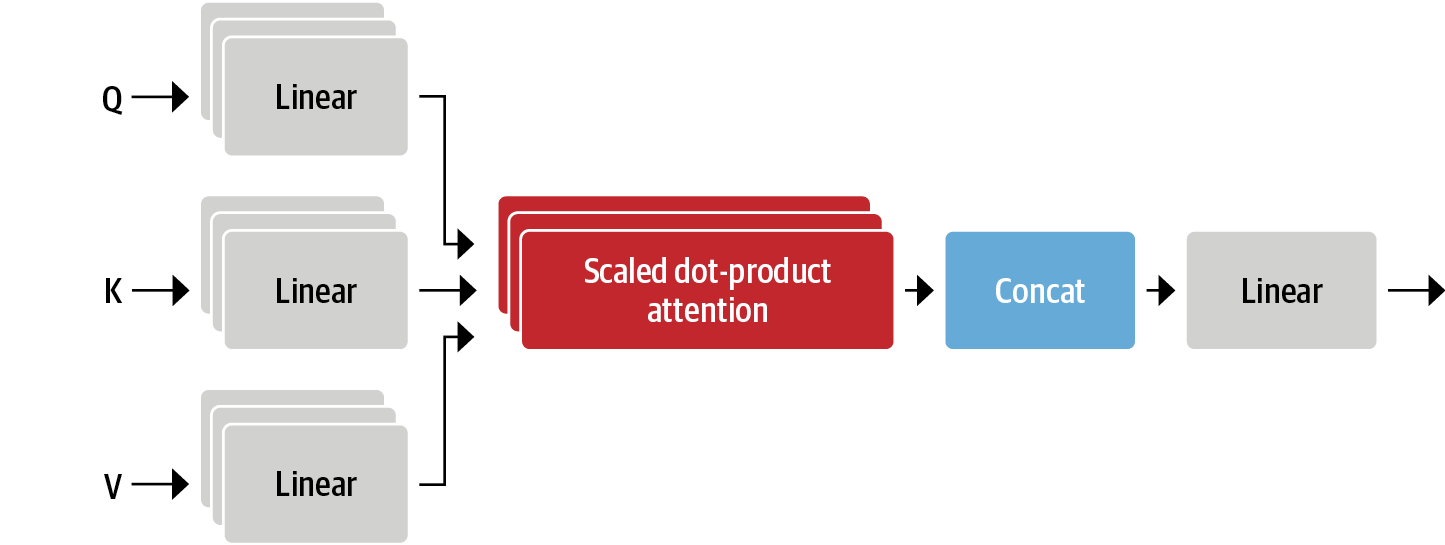

# MULTI HEADED ATTENTION

In [122]:
class AttentionHead(nn.Module): #
    def __init__(self,embed_dim,head_dim):
        super().__init__()
        self.q=nn.Linear(embed_dim,head_dim)
        self.k=nn.Linear(embed_dim,head_dim)
        self.v=nn.Linear(embed_dim,head_dim)
    def forward(self,hidden_state):
        attn_outputs=scaled_product_attention(self.q(hidden_state),self.k(hidden_state),self.v(hidden_state))
        return attn_outputs

In [123]:
class MultiHeadAttention(nn.Module): ##CONVERTS multi head to linear
    def __init__(self,config):
        super().__init__()
        embed_dim=config.hidden_size
        num_heads=config.num_attention_heads
        head_dim=embed_dim//num_heads
        self.heads=nn.ModuleList([AttentionHead(embed_dim,head_dim) for _ in range(num_heads)])
        self.output_linear=nn.Linear(embed_dim,embed_dim)
    def forward(self,hidden_state):
        x=torch.cat([h(hidden_state) for h in self.heads],dim=-1)
        x=self.output_linear(x)
        return x

In [124]:
multihead_attn=MultiHeadAttention(config)

In [125]:
attn_output=multihead_attn(input_embeds)

In [126]:
attn_output


tensor([[[ 0.3753, -0.0591, -0.1108,  ..., -0.0827,  0.0286,  0.0432],
         [ 0.3629, -0.0712, -0.1239,  ..., -0.1403,  0.0805, -0.0073],
         [ 0.2870, -0.0227, -0.1650,  ..., -0.1100, -0.0695, -0.0382],
         ...,
         [ 0.3430, -0.0102, -0.1544,  ..., -0.1120,  0.0106, -0.0033],
         [ 0.3240, -0.0615, -0.2169,  ..., -0.0877,  0.0057,  0.0212],
         [ 0.3441, -0.0443, -0.1671,  ..., -0.1301, -0.0292,  0.0141]]],
       grad_fn=<ViewBackward0>)

# VISUALISATION

In [127]:
from bertviz import head_view
from transformers import AutoModel

In [128]:
model=AutoModel.from_pretrained(model_name,output_attentions=True)

In [129]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [130]:
sent_a="time flies like an arrow"
sent_b="fruit flies like a banana"

In [131]:
viz_inputs=tokenizer(sent_a,sent_b,return_tensors="pt")

In [132]:
attention=model(**viz_inputs).attentions

In [133]:
sent_b_start=(viz_inputs.token_type_ids==0).sum(dim=1)

In [134]:
sent_b_start

tensor([7])

In [135]:
tokens=tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])
tokens

['[CLS]',
 'time',
 'flies',
 'like',
 'an',
 'arrow',
 '[SEP]',
 'fruit',
 'flies',
 'like',
 'a',
 'banana',
 '[SEP]']

In [136]:

head_view(attention,tokens,sent_b_start,heads=[8],html_action="return")

In [137]:
class FeedForward(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.linear_1=nn.Linear(config.hidden_size,config.intermediate_size)
        self.linear_2=nn.Linear(config.intermediate_size,config.hidden_size)
        self.gelu=nn.GELU()
        self.dropout=nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self,x):
        x=self.linear_1(x)
        x=self.gelu(x)
        x=self.linear_2(x)
        x=self.dropout(x)
        return x

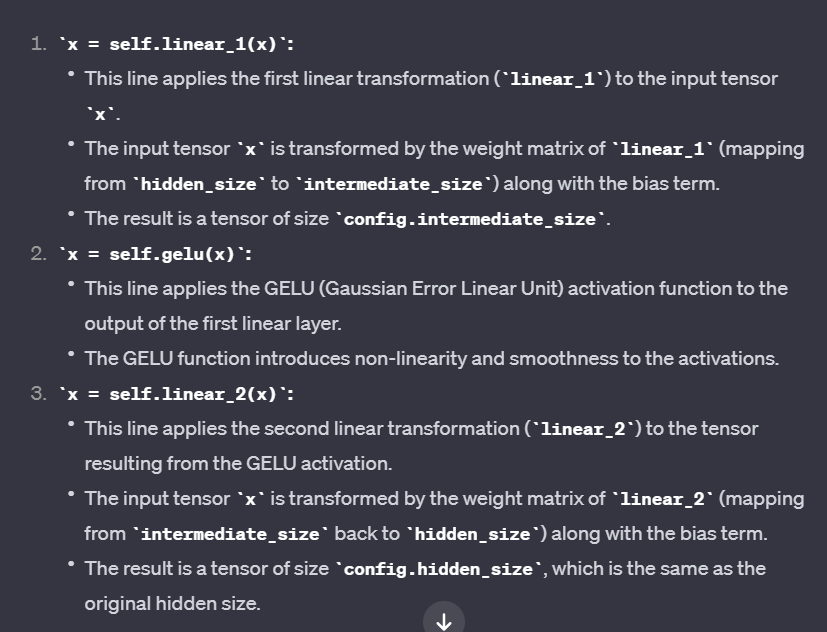


In [138]:
feed_forward=FeedForward(config)
ff_outputs=feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 7, 768])

In [139]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.layer_norm_1=nn.LayerNorm(config.hidden_size)
        self.layer_norm_2=nn.LayerNorm(config.hidden_size)
        self.attention=MultiHeadAttention(config)
        self.feed_forward=FeedForward(config)
    def forward(self,x):
        hidden_state=self.layer_norm_1(x)
        x=x+self.attention(hidden_state)
        x=x+self.feed_forward(self.layer_norm_2(x))
        return x

# POSITION EMBEDDINGS

In [140]:
class Embeddings (nn.Module):
    def __init__(self,config):
        super().__init__()
        self.token_embeddings=nn.Embedding(config.vocab_size,config.hidden_size)
        self.position_embeddings=nn.Embedding(config.max_position_embeddings,config.hidden_size)
        self.layer_norm=nn.LayerNorm(config.hidden_size,eps=1e-12)
        self.dropout=nn.Dropout()
    def forward(self,input_ids):
        seq_length=input_ids.size(1)
        position_ids=torch.arange(seq_length,dtype=torch.long).unsqueeze(0)
        token_embeddings=self.token_embeddings(input_ids)
        position_embeddings=self.position_embeddings(position_ids)
        embeddings=token_embeddings+position_embeddings
        embeddings=self.layer_norm(embeddings)
        embeddings=self.dropout(embeddings)
        return embeddings
embedding_layer=Embeddings(config)

In [141]:
embedding_layer(inputs.input_ids).size()

torch.Size([1, 7, 768])

In [142]:
embedding_layer(inputs.input_ids)

tensor([[[-1.8865, -0.0000, -0.0000,  ..., -0.0000,  2.8123, -1.4044],
         [-0.0000, -0.5644,  0.0000,  ..., -1.3629, -0.0000,  0.0000],
         [-0.0000,  1.1933,  0.5490,  ...,  0.0000,  0.9590,  0.4684],
         ...,
         [-3.8133,  0.0000,  2.5762,  ...,  1.8830,  2.4461, -1.5639],
         [ 0.0000,  0.0000, -0.0000,  ..., -1.7016, -0.0000,  0.7087],
         [ 0.0000,  0.0000,  0.0000,  ..., -2.6449,  0.0000,  2.2535]]],
       grad_fn=<MulBackward0>)

#  CODING COMPLETE TRANSFORMER ENCODER

In [143]:
class TransformerEncoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embeddings=Embeddings(config)
        self.layers=nn.ModuleList(TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers))
    def forward(self,x):
        x=self.embeddings(x)
        for layer in self.layers:
            x=layer(x)
        return x

In [144]:
encoder=TransformerEncoder(config)

In [145]:
encoder(inputs.input_ids).size()

torch.Size([1, 7, 768])

In [146]:
class TransformerForSequenceClassificaiton(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.encoder=TransformerEncoder(config)
        self.dropout=nn.Dropout(config.hidden_dropout_prob)
        self.classfier=nn.Linear(config.hidden_size,config.num_labels)
    def forward(self,x):
        x=self.encoder(x)[:,0,:]
        x=self.dropout(x)
        x=self.classfier(x)
        return x

In [147]:
config.num_labels=3
encoder_classifier=TransformerForSequenceClassificaiton(config)
encoder_classifier(inputs.input_ids)

tensor([[1.2362, 0.9737, 0.8158]], grad_fn=<AddmmBackward0>)

# ENCODER DONE